# Best XGB Model from Feb 9th
### Circled back to earlier XGB model from Feb 9th that was balanced
### Feb 10 runs were ok but model was unbalanced

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime 
import datetime as dt
import matplotlib.pyplot as plt

# Load and Prep Data

In [10]:
# Prep data for ML

#Load balanced data
#Even re-sample of delay and no delay from orig dataset
flights = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Data\cleaned\cleaned_balanced_sample.csv', delimiter=',', low_memory=False)
flights.head()

#Add Date Featues to table
flights['year'] = pd.to_datetime(flights['fl_date']).dt.year
flights['quarter'] = pd.to_datetime(flights['fl_date']).dt.quarter
flights['month'] = pd.to_datetime(flights['fl_date']).dt.month
flights['day_of_month'] = pd.to_datetime(flights['fl_date']).dt.day
flights['day_of_week'] = pd.to_datetime(flights['fl_date']).dt.dayofweek

#Add time features to table
flights['crs_dep_hour'] = pd.to_datetime(flights['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour
flights['crs_arr_hour'] = pd.to_datetime(flights['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour

#Add column with delay or no delay
flights['arr_delay_flag'] = flights['arr_delay'].map(lambda x: 1 if x > 0 else 0)

#Import weather data
weather = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Weather2\weather_table.csv', delimiter=',', low_memory=False)

#Add weather data to flights
flights = pd.merge(flights, weather, how='left', left_on=['fl_date', 'dest'], right_on = ['date_time', 'location'])

# Drop nas
flights = flights[flights['weather_type'].notna()]

#Remove duplicate columns
flights = flights.loc[:,~flights.columns.duplicated()]

# XGB Model with 300 trees

In [158]:
# XGB Model
# Classifier
# Updated features included - Added weather_type

# assign X and y
cols = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 
        'crs_arr_time', 'crs_elapsed_time', 'distance', 'weather_type']
X = flights[cols]
y = flights['arr_delay_flag']

# encode categorical columns
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cat_vars = X.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

# make train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xsc = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xsc, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model3 = xgb.XGBClassifier(objective = 'reg:squarederror', n_estimators=300)
model3 = model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_score = model3.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

<ipython-input-158-03b0a21e57d4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.55      0.56      0.55     90082
           1       0.55      0.54      0.55     89912

    accuracy                           0.55    179994
   macro avg       0.55      0.55      0.55    179994
weighted avg       0.55      0.55      0.55    179994

Accuracy: 0.5486627332022178
F1 Score: 0.5451399776035835
Recall: 0.5414293976332414
Precision: 0.5489017679956703
AUC Score: 0.5638287876091161


# XGB with 1000 trees

In [26]:
# XGB Model
# Classifier
# Updated features included - Added weather_type

# assign X and y
cols = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 
        'crs_arr_time', 'crs_elapsed_time', 'distance', 'weather_type']
X = flights[cols]
y = flights['arr_delay_flag']

# encode categorical columns
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cat_vars = X.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

# make train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xsc = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xsc, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=1000, learning_rate=0.001, max_depth=12)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

<ipython-input-26-bece2246c1e5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.56      0.55      0.55     90082
           1       0.55      0.56      0.56     89912

    accuracy                           0.56    179994
   macro avg       0.56      0.56      0.56    179994
weighted avg       0.56      0.56      0.56    179994

Accuracy: 0.5552740646910452
F1 Score: 0.5582827502483169
Recall: 0.562616780852389
Precision: 0.5540149822578525
AUC Score: 0.5731540258707927


Text(0.5, 637.6, 'Predicted label')

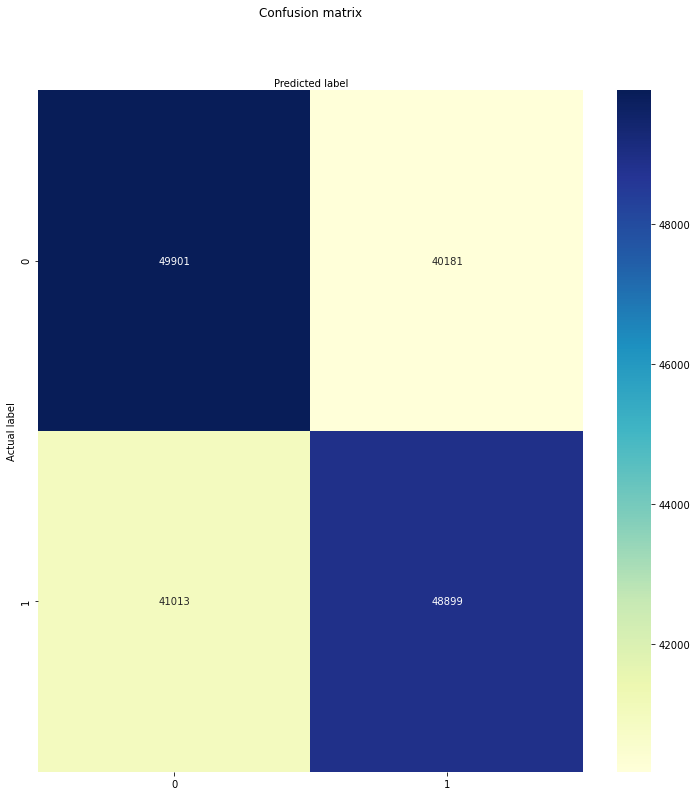

In [35]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# create heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# XGB with 300 Trees and numeric weather columns added

In [43]:
# XGB Model
# Classifier
# Updated features included - Added weather_type

# assign X and y
cols = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 
        'crs_arr_time', 'crs_elapsed_time', 'distance', 'weather_type', 'totalSnow_cm', 'sunHour', 'cloudcover', 'precipMM']
X = flights[cols]
y = flights['arr_delay_flag']

# encode categorical columns
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cat_vars = X.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

# make train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xsc = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xsc, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model2 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric='auc', n_estimators=300)
model2 = model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_score = model2.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

<ipython-input-43-56fe31231d15>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.55      0.55      0.55     90082
           1       0.55      0.54      0.55     89912

    accuracy                           0.55    179994
   macro avg       0.55      0.55      0.55    179994
weighted avg       0.55      0.55      0.55    179994

Accuracy: 0.548907185795082
F1 Score: 0.5463819612049701
Recall: 0.5438539905685559
Precision: 0.5489335428828019
AUC Score: 0.5652769092678003


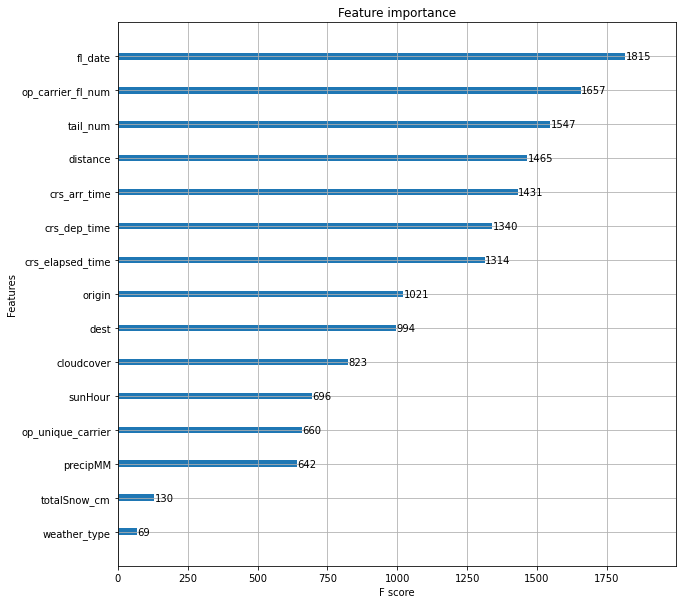

In [51]:
# Feature Importance Plot
model2.get_booster().feature_names = cols
fig = xgb.plot_importance(model2.get_booster())
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()